## Clustering Evaluation

### All imports here

In [31]:
import json
import numpy as np
from sklearn import metrics
from scipy.spatial import distance

In [32]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Functions

In [33]:
def parse_distance_matrix(pic_matrix_json):
    """
    parse distance matrix output from pic clustering algorithm
    @arg pic_matrix_json json file containing pic clustering distance
    @return distance dictionary and set of pois
    """
    distance_dict, pois = {}, set()
    for item in pic_matrix_json['distances']:
        pois.add(item['poi1'])
        pois.add(item['poi2'])
        if item['poi1'] not in distance_dict.keys():
            distance_dict[item['poi1']] = {item['poi2']: item['distance']}
        else:
            distance_dict[item['poi1']][item['poi2']] = item['distance']
    return distance_dict, pois

def build_distance_matrix(distance_dict, pois):
    """
    build distance matrix from distance dictionary and set of pois, key error should never be thrown here
    """
    matrix = []
    for poi_i in pois:  # each row
        row = []
        for poi_j in pois:  # each column
            if poi_i == poi_j:  # diagonal
                row.append(0.0)
            elif poi_i in distance_dict.keys():  # if there is relation between poi_i and poi_j
                if poi_j in distance_dict[poi_i].keys():
                    row.append(distance_dict[poi_i][poi_j])
                else:
                    row.append(distance_dict[poi_j][poi_i])
            else:  # if there is relation between poi_i and poi_j
                row.append(1.0)
        matrix.append(np.array(row))
    return np.array(matrix)

def parse_clustering_result(clusters_json):
    """
    parse clustering result to get cluster id and corresponding pois in cluster
    """
    clusters = {}
    for cluster in clusters_json['clusters']:
        if cluster['cluster_id'] not in clusters:
            clusters[cluster['cluster_id']] = []
        for poi in cluster['poi_in_cluster']:
            clusters[cluster['cluster_id']].append(poi['poi_id'])
    return clusters

def build_label(clusters, pois):
    """
    get cluster label for each poi from clusters and pois
    """
    poi_cluster_label = {}
    for key, value in clusters.items():  # for each cluster_i and pois_in_cluster_i
        for poi in value:  # for each poi in cluster_i
            assert poi not in poi_cluster_label.keys()  # poi shouldn't be labeled, poi assigned to one cluster only
            poi_cluster_label[poi] = key
    
    labels = []
    for poi in pois:  # get cluster label for each poi from poi_cluster dict
        labels.append(poi_cluster_label[poi])
    return np.array(labels)

def build_mds_distance_matrix(poi_coordinates, pois):
    """
    build distance matrix from mds coordinates, so far 2-dimensional space
    """
    mds_matrix = []
    for poi_i in pois:
        row = []
        for poi_j in pois:
            if poi_i == poi_j:
                row.append(0)
            else:
                row.append(distance.euclidean(poi_coordinates[poi_i], poi_coordinates[poi_j]))
        mds_matrix.append(row)
    return np.array(mds_matrix)

### PIC

In [34]:
with open('../../results/pic_matrix.json') as pic_matrix:
    pic_matrix_json = json.load(pic_matrix)

In [35]:
distance_dict, pois = parse_distance_matrix(pic_matrix_json)

In [36]:
matrix = build_distance_matrix(distance_dict, pois)

In [37]:
with open('../../results/pic_clusters.json') as pic_clusters:
    pic_clusters_json = json.load(pic_clusters)

In [38]:
clusters = parse_clustering_result(pic_clusters_json)

In [39]:
labels = build_label(clusters, pois)

In [40]:
metrics.silhouette_score(matrix, labels, metric='precomputed')

0.45147020556856621

In [41]:
#metrics.calinski_harabaz_score(matrix, labels)

### MDS

In [42]:
with open('../../results/mds_coordinates.json') as mds_coordinates:
    mds_coordinates_json = json.load(mds_coordinates)

In [43]:
poi_coordinates = {}
for item in mds_coordinates_json['coordinates']:
    poi_coordinates[item['poiID']] = (item['coordinate'][0], item['coordinate'][1])

In [44]:
mds_matrix = build_mds_distance_matrix(poi_coordinates, pois)

In [45]:
with open('../../results/mds_kmeans_clusters.json') as mds_kmeans_clusters:
    mds_kmeans_clusters_json = json.load(mds_kmeans_clusters)

In [46]:
mds_clusters = parse_clustering_result(mds_kmeans_clusters_json)

In [47]:
mds_labels = build_label(mds_clusters, pois)

In [48]:
mds_clusters_coordinate = {}
for key, values in mds_clusters.items():
    if key not in mds_clusters_coordinate.keys():
        mds_clusters_coordinate[key] = {'x': [], 'y': []}
    for value in values:
        mds_clusters_coordinate[key]['x'].append(poi_coordinates[value][0])
        mds_clusters_coordinate[key]['y'].append(poi_coordinates[value][1])

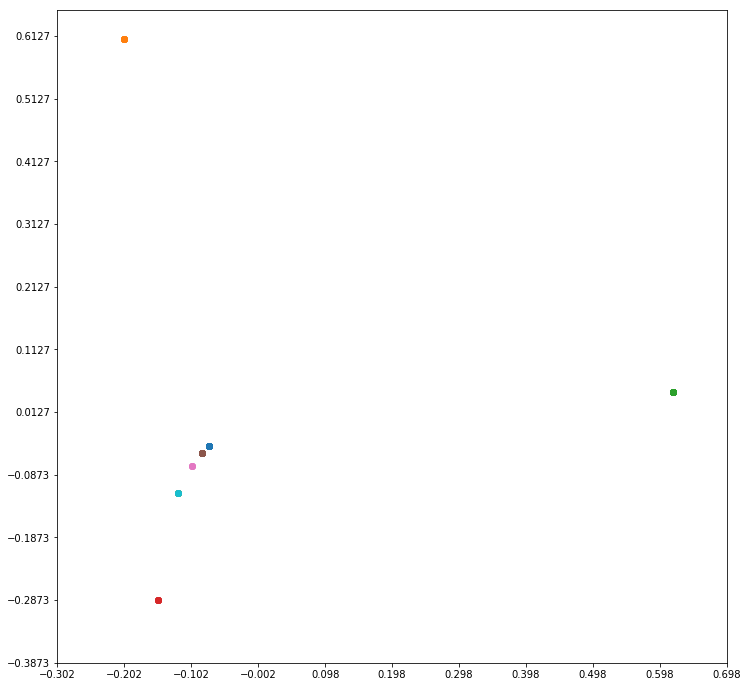

In [49]:
NUM_COLORS = len(mds_clusters_coordinate)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
min_x, max_x, min_y, max_y = None, None, None, None
for i in range(NUM_COLORS):
    if min_x is None or min_x > min(mds_clusters_coordinate[i]['x']):
        min_x = min(mds_clusters_coordinate[i]['x'])
    if max_x is None or max_x < max(mds_clusters_coordinate[i]['x']):
        max_x = max(mds_clusters_coordinate[i]['x'])
    if min_y is None or min_y > min(mds_clusters_coordinate[i]['y']):
        min_y = min(mds_clusters_coordinate[i]['y'])
    if max_y is None or max_y < max(mds_clusters_coordinate[i]['y']):
        max_y = max(mds_clusters_coordinate[i]['y'])
    ax.scatter(mds_clusters_coordinate[i]['x'], mds_clusters_coordinate[i]['y'])
plt.xticks(np.arange(min_x-0.1, max_x+0.1, step=0.1))
plt.yticks(np.arange(min_y-0.1, max_y+0.1, step=0.1))
plt.show()

In [50]:
metrics.silhouette_score(mds_matrix, mds_labels, metric='precomputed')

0.96063752993180007

### OneHot Encoding

In [51]:
with open('../../results/oneHotMatrix.json') as one_hot:
    one_hot_encoded = json.load(one_hot)

In [52]:
poi_encoding = {}
for item in one_hot_encoded:
    poi_encoding[item[0]] = item[1:]

In [53]:
with open('../../results/oneHot_kmeans_clusters.json') as onehot_kmeans_clusters:
    onehot_kmeans_clusters_json = json.load(onehot_kmeans_clusters)

In [54]:
onehot_clusters = parse_clustering_result(onehot_kmeans_clusters_json)

In [55]:
onehot_matrix, poi_new = [], []
for poi_i, poi_i_code in poi_encoding.items():
    poi_new.append(poi_i)
    row = []
    for poi_j, poi_j_code in poi_encoding.items():
        if poi_i == poi_j:
            row.append(0)
        else:
            row.append(distance.euclidean(poi_i_code, poi_j_code))
    onehot_matrix.append(row)
onehot_matrix = np.array(onehot_matrix)

In [56]:
onehot_labels = build_label(onehot_clusters, poi_new)

In [57]:
metrics.silhouette_score(onehot_matrix, onehot_labels, metric='precomputed')

0.42987776929934596